## Bibiliothèque

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from resnet import resnet_layer, resnet_v1
from Distiller_beta import Distiller_AdaIn, Distiller
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
seed = tf.random.set_seed(10)


2022-05-16 09:38:06.569176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-16 09:38:06.569220: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Utils

In [2]:
def plot_hist_kd(hist, figname):
    #History
    plt.figure(figsize=(20,7))
    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'], label = "train accur")
    plt.plot(hist.history['val_sparse_categorical_accuracy'], label = "Val accur")
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title("Accuracy")
    plt.grid()
    plt.legend()


    plt.subplot(122)
    plt.plot(hist.history['student_loss'], label = "student Loss")
    plt.plot(hist.history['val_student_loss'], label = "Val loss")
    plt.xlabel('Epochs')
    plt.ylabel('Student Loss')
    plt.title("Loss")
    plt.grid()
    plt.legend()
    
    plt.savefig(figname)
    
    plt.show()

## Loading cifar10 Dataset

In [3]:
print("================ Data Loading ================")
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Data shapes
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("")

================ Data Loading ================
x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)
y_train shape: (50000, 1)
y_test shape: (10000, 1)



## Loading Resnet26 Teacher model

In [4]:
print("")
print("================ Loading teacher model ================")
teacher = tf.keras.models.load_model("Resnet26_from_logits")
print("Evaluation of Teacher model!")
teacher.evaluate(x_test, y_test)
print("")



================ Loading teacher model ================


2022-05-16 09:38:14.535942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-16 09:38:14.536112: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-16 09:38:14.536188: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (big25): /proc/driver/nvidia/version does not exist
2022-05-16 09:38:14.536705: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Evaluation of Teacher model!
313/313 [==============================] - 9s 26ms/step - loss: 0.5328 - sparse_categorical_accuracy: 0.9054



## Creating a data augmentation process

In [5]:
print("================ Building dataGen ================")
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(x_train)

================ Building dataGen ================


## Building a preprocessing routine

In [6]:
print(" ============== Adding preprocessing layers ===============")
preprocessing = tf.keras.Sequential([
    tf.keras.layers.RandomCrop(32, 32, seed= seed),
    tf.keras.layers.RandomFlip(mode="horizontal", seed= seed),

])

 ============== Adding preprocessing layers ===============


## Building Resnet8 Student model 

In [7]:
print("============== Building Student Network Resnet8 ! =============")

student = resnet_v1(input_shape=(32, 32, 3), depth= 8)

student = tf.keras.Sequential([
    preprocessing,
    student,   
])



student_scratch = tf.keras.models.clone_model(student)

print("")

============== Building Student Network Resnet8 ! =============



## Building callbacks

In [8]:
model_save = tf.keras.callbacks.ModelCheckpoint(
    "/callback/callback_save",
    monitor='val_student_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_student_loss',
    factor=0.1,
    patience=10,
    verbose=1,
    mode='min',
    
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.000001,
)


## Knowledge distillation

In [9]:
BATCH_SIZE = 32
EPOCHS = 100
A = [ 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
lr = 0.1


Epoch 1/100
1562/1562 [==============================] - 82s 50ms/step - sparse_categorical_accuracy: 0.4652 - student_loss: 1.4544 - Dist_loss: 1.4196 - loss: 1.5964 - val_sparse_categorical_accuracy: 0.4899 - val_student_loss: 2.4056 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.6265 - student_loss: 1.0499 - Dist_loss: 1.1855 - loss: 1.1685 - val_sparse_categorical_accuracy: 0.5711 - val_student_loss: 3.4276 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6848 - student_loss: 0.8946 - Dist_loss: 1.0721 - loss: 1.0018 - val_sparse_categorical_accuracy: 0.5794 - val_student_loss: 1.5068 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.7222 - student_loss: 0.7910 - Dist_loss: 0.9893 - loss: 0.8900 - val_sparse_categorical_accuracy: 0.6422 - val_student_loss: 1.3320 - lr: 0.1000
Epoc

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9209 - student_loss: 0.2254 - Dist_loss: 0.4069 - loss: 0.2661 - val_sparse_categorical_accuracy: 0.8300 - val_student_loss: 2.3755 - lr: 0.0100
Epoch 33/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9265 - student_loss: 0.2128 - Dist_loss: 0.3989 - loss: 0.2527 - val_sparse_categorical_accuracy: 0.8323 - val_student_loss: 2.3748 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9269 - student_loss: 0.2111 - Dist_loss: 0.3966 - loss: 0.2507 - val_sparse_categorical_accuracy: 0.8335 - val_student_loss: 2.3804 - lr: 1.0000e-03
Epoch 35/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9261 - student_loss: 0.2080 - Dist_loss: 0.3961 - loss: 0.2476 - val_sparse_categorical_accuracy: 0.8328 - val_student_loss: 2.3781 - lr: 1.0000e-03
E

1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9298 - student_loss: 0.2027 - Dist_loss: 0.3879 - loss: 0.2415
Epoch 62: ReduceLROnPlateau reducing learning rate to 1e-06.
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9298 - student_loss: 0.2027 - Dist_loss: 0.3879 - loss: 0.2415 - val_sparse_categorical_accuracy: 0.8335 - val_student_loss: 2.3770 - lr: 1.0000e-05
Epoch 63/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9314 - student_loss: 0.2030 - Dist_loss: 0.3877 - loss: 0.2418 - val_sparse_categorical_accuracy: 0.8336 - val_student_loss: 2.3767 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9314 - student_loss: 0.2009 - Dist_loss: 0.3870 - loss: 0.2396 - val_sparse_categorical_accuracy: 0.8340 - val_student_loss: 2.3774 - lr: 1.0000e-06
Epoch 65/100
1562/1562 [=================

1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9295 - student_loss: 0.2033 - Dist_loss: 0.3866 - loss: 0.2419 - val_sparse_categorical_accuracy: 0.8341 - val_student_loss: 2.3715 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9303 - student_loss: 0.2034 - Dist_loss: 0.3883 - loss: 0.2422 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 2.3744 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9294 - student_loss: 0.2049 - Dist_loss: 0.3875 - loss: 0.2437 - val_sparse_categorical_accuracy: 0.8341 - val_student_loss: 2.3790 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9297 - student_loss: 0.2020 - Dist_loss: 0.3863 - loss: 0.2406 - val_sparse_categorical_accuracy: 0.8338 - val_student_loss: 2.3751 - lr: 1.0000e-

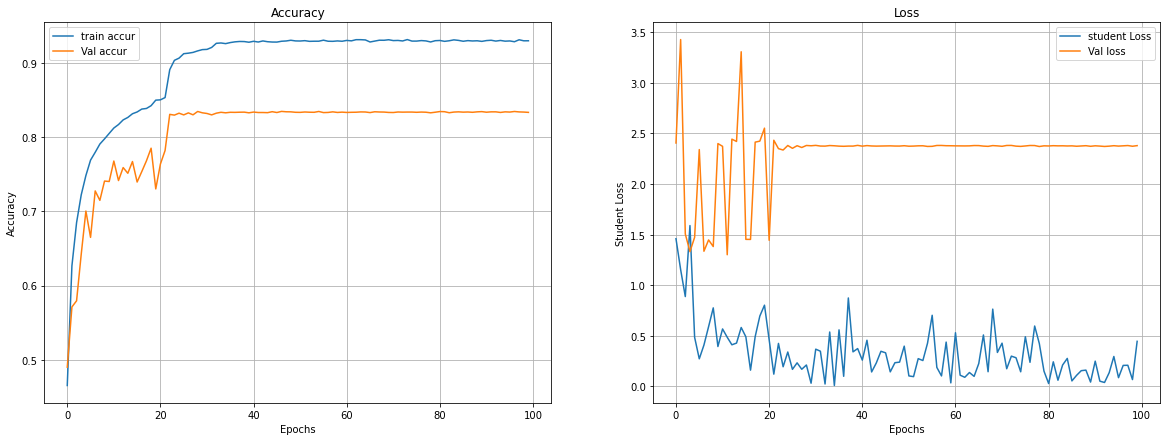

Saving model 


2022-05-16 11:44:22.783382: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.1/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 81s 50ms/step - sparse_categorical_accuracy: 0.4747 - student_loss: 1.4335 - Dist_loss: 1.3910 - loss: 1.7117 - val_sparse_categorical_accuracy: 0.5211 - val_student_loss: 1.4603 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6274 - student_loss: 1.0487 - Dist_loss: 1.1483 - loss: 1.2783 - val_sparse_categorical_accuracy: 0.6012 - val_student_loss: 1.5161 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.6832 - student_loss: 0.9047 - Dist_loss: 1.0358 - loss: 1.1119 - val_sparse_categorical_accuracy: 0.6192 - val_student_loss: 1.4498 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.7190 - student_loss: 0.8098 

1562/1562 [==============================] - 79s 50ms/step - sparse_categorical_accuracy: 0.9030 - student_loss: 0.2792 - Dist_loss: 0.4284 - loss: 0.3649 - val_sparse_categorical_accuracy: 0.8316 - val_student_loss: 1.5110 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9041 - student_loss: 0.2764 - Dist_loss: 0.4264 - loss: 0.3616 - val_sparse_categorical_accuracy: 0.8317 - val_student_loss: 1.4989 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9032 - student_loss: 0.2781 - Dist_loss: 0.4268 - loss: 0.3635 - val_sparse_categorical_accuracy: 0.8317 - val_student_loss: 1.5102 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9051 - student_loss: 0.2756 - Dist_loss: 0.4245 - loss: 0.3605 - val_sparse_categorical_accuracy: 0.8327 - val_student_loss: 1.5060 - lr: 1.0000e-

Epoch 61/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9055 - student_loss: 0.2696 - Dist_loss: 0.4207 - loss: 0.3537 - val_sparse_categorical_accuracy: 0.8323 - val_student_loss: 1.5136 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9044 - student_loss: 0.2739 - Dist_loss: 0.4220 - loss: 0.3583 - val_sparse_categorical_accuracy: 0.8315 - val_student_loss: 1.5138 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9071 - student_loss: 0.2710 - Dist_loss: 0.4214 - loss: 0.3553 - val_sparse_categorical_accuracy: 0.8318 - val_student_loss: 1.5086 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9056 - student_loss: 0.2708 - Dist_loss: 0.4212 - loss: 0.3551 - val_sparse_categorical_accuracy: 0.8319 - val_student_loss: 1.5165 -

1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9061 - student_loss: 0.2702 - Dist_loss: 0.4218 - loss: 0.3546 - val_sparse_categorical_accuracy: 0.8321 - val_student_loss: 1.5088 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9062 - student_loss: 0.2689 - Dist_loss: 0.4208 - loss: 0.3531 - val_sparse_categorical_accuracy: 0.8319 - val_student_loss: 1.5030 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9070 - student_loss: 0.2714 - Dist_loss: 0.4216 - loss: 0.3557 - val_sparse_categorical_accuracy: 0.8326 - val_student_loss: 1.5099 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9062 - student_loss: 0.2692 - Dist_loss: 0.4205 - loss: 0.3533 - val_sparse_categorical_accuracy: 0.8320 - val_student_loss: 1.5165 - lr: 1.0000e-

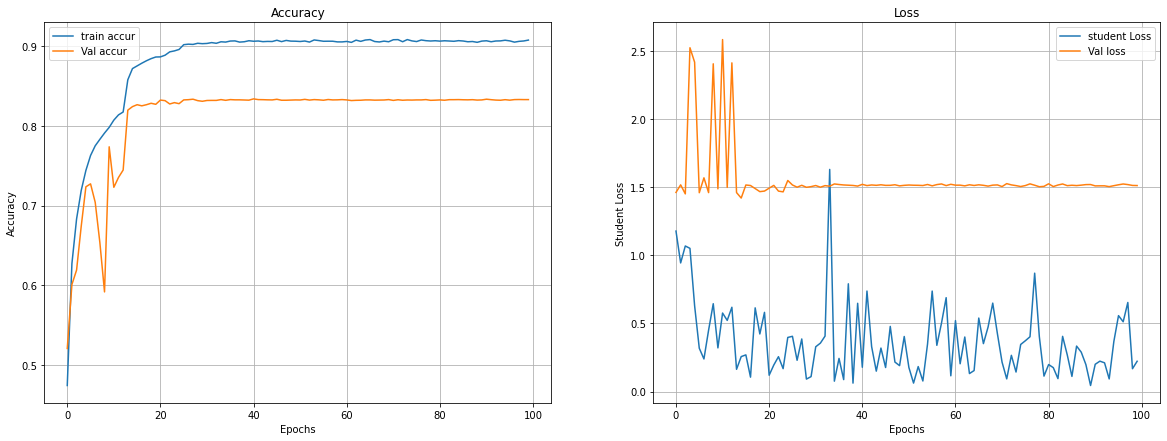

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.2/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 81s 49ms/step - sparse_categorical_accuracy: 0.4511 - student_loss: 1.4948 - Dist_loss: 1.4070 - loss: 1.9169 - val_sparse_categorical_accuracy: 0.3876 - val_student_loss: 2.5254 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6172 - student_loss: 1.0842 - Dist_loss: 1.1414 - loss: 1.4266 - val_sparse_categorical_accuracy: 0.5770 - val_student_loss: 1.5349 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6687 - student_loss: 0.9467 - Dist_loss: 1.0236 - loss: 1.2538 - val_sparse_categorical_accuracy: 0.6326 - val_student_loss: 1.5032 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.7045 - student

Epoch 31/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.8991 - student_loss: 0.2922 - Dist_loss: 0.4015 - loss: 0.4126 - val_sparse_categorical_accuracy: 0.8273 - val_student_loss: 1.5007 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.8977 - student_loss: 0.2948 - Dist_loss: 0.4009 - loss: 0.4151 - val_sparse_categorical_accuracy: 0.8275 - val_student_loss: 1.4921 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.8985 - student_loss: 0.2954 - Dist_loss: 0.3999 - loss: 0.4153 - val_sparse_categorical_accuracy: 0.8282 - val_student_loss: 1.4917 - lr: 1.0000e-03
Epoch 34/100
1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9004 - student_loss: 0.2916 - Dist_loss: 0.3996 - loss: 0.4115
Epoch 34: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.

Epoch 61/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9012 - student_loss: 0.2890 - Dist_loss: 0.3967 - loss: 0.4080 - val_sparse_categorical_accuracy: 0.8275 - val_student_loss: 1.4905 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9008 - student_loss: 0.2891 - Dist_loss: 0.3974 - loss: 0.4083 - val_sparse_categorical_accuracy: 0.8271 - val_student_loss: 1.4939 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9011 - student_loss: 0.2913 - Dist_loss: 0.3969 - loss: 0.4104 - val_sparse_categorical_accuracy: 0.8278 - val_student_loss: 1.4916 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.8996 - student_loss: 0.2904 - Dist_loss: 0.3966 - loss: 0.4094 - val_sparse_categorical_accuracy: 0.8288 - val_student_loss: 1.4953 -

1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9013 - student_loss: 0.2879 - Dist_loss: 0.3964 - loss: 0.4068 - val_sparse_categorical_accuracy: 0.8282 - val_student_loss: 1.4955 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9012 - student_loss: 0.2892 - Dist_loss: 0.3969 - loss: 0.4083 - val_sparse_categorical_accuracy: 0.8279 - val_student_loss: 1.4886 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9010 - student_loss: 0.2899 - Dist_loss: 0.3969 - loss: 0.4090 - val_sparse_categorical_accuracy: 0.8281 - val_student_loss: 1.4938 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9020 - student_loss: 0.2900 - Dist_loss: 0.3964 - loss: 0.4089 - val_sparse_categorical_accuracy: 0.8278 - val_student_loss: 1.4961 - lr: 1.0000e-

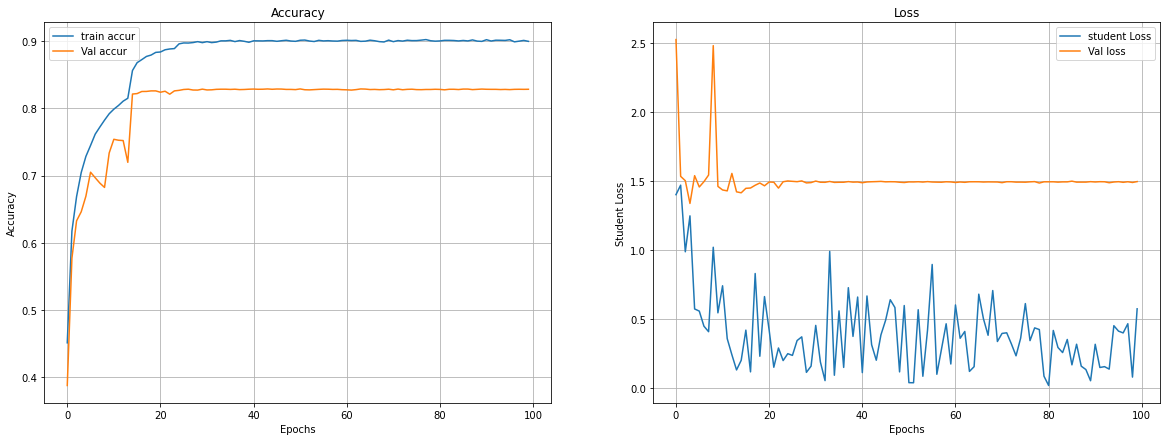

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.3/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 80s 49ms/step - sparse_categorical_accuracy: 0.4554 - student_loss: 1.4834 - Dist_loss: 1.3837 - loss: 2.0368 - val_sparse_categorical_accuracy: 0.4544 - val_student_loss: 1.4426 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6115 - student_loss: 1.1069 - Dist_loss: 1.1239 - loss: 1.5565 - val_sparse_categorical_accuracy: 0.5255 - val_student_loss: 1.5590 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.6660 - student_loss: 0.9631 - Dist_loss: 0.9955 - loss: 1.3613 - val_sparse_categorical_accuracy: 0.6130 - val_student_loss: 1.4310 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.7027 - student

Epoch 31/100
1562/1562 [==============================] - 79s 51ms/step - sparse_categorical_accuracy: 0.9075 - student_loss: 0.2729 - Dist_loss: 0.3437 - loss: 0.4104 - val_sparse_categorical_accuracy: 0.8341 - val_student_loss: 1.4515 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9079 - student_loss: 0.2684 - Dist_loss: 0.3419 - loss: 0.4052 - val_sparse_categorical_accuracy: 0.8335 - val_student_loss: 1.4543 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9092 - student_loss: 0.2663 - Dist_loss: 0.3409 - loss: 0.4027 - val_sparse_categorical_accuracy: 0.8327 - val_student_loss: 1.4538 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9089 - student_loss: 0.2707 - Dist_loss: 0.3407 - loss: 0.4069 - val_sparse_categorical_accuracy: 0.8320 - val_student_loss: 1.4503 -

Epoch 61/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9105 - student_loss: 0.2607 - Dist_loss: 0.3346 - loss: 0.3945 - val_sparse_categorical_accuracy: 0.8329 - val_student_loss: 1.4572 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9109 - student_loss: 0.2595 - Dist_loss: 0.3350 - loss: 0.3935 - val_sparse_categorical_accuracy: 0.8330 - val_student_loss: 1.4558 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9106 - student_loss: 0.2615 - Dist_loss: 0.3358 - loss: 0.3958 - val_sparse_categorical_accuracy: 0.8328 - val_student_loss: 1.4582 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9110 - student_loss: 0.2591 - Dist_loss: 0.3343 - loss: 0.3928 - val_sparse_categorical_accuracy: 0.8322 - val_student_loss: 1.4596 -

1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9092 - student_loss: 0.2634 - Dist_loss: 0.3352 - loss: 0.3974 - val_sparse_categorical_accuracy: 0.8320 - val_student_loss: 1.4612 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9104 - student_loss: 0.2617 - Dist_loss: 0.3344 - loss: 0.3955 - val_sparse_categorical_accuracy: 0.8327 - val_student_loss: 1.4546 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9106 - student_loss: 0.2618 - Dist_loss: 0.3353 - loss: 0.3959 - val_sparse_categorical_accuracy: 0.8322 - val_student_loss: 1.4556 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9106 - student_loss: 0.2617 - Dist_loss: 0.3345 - loss: 0.3955 - val_sparse_categorical_accuracy: 0.8330 - val_student_loss: 1.4570 - lr: 1.0000e-

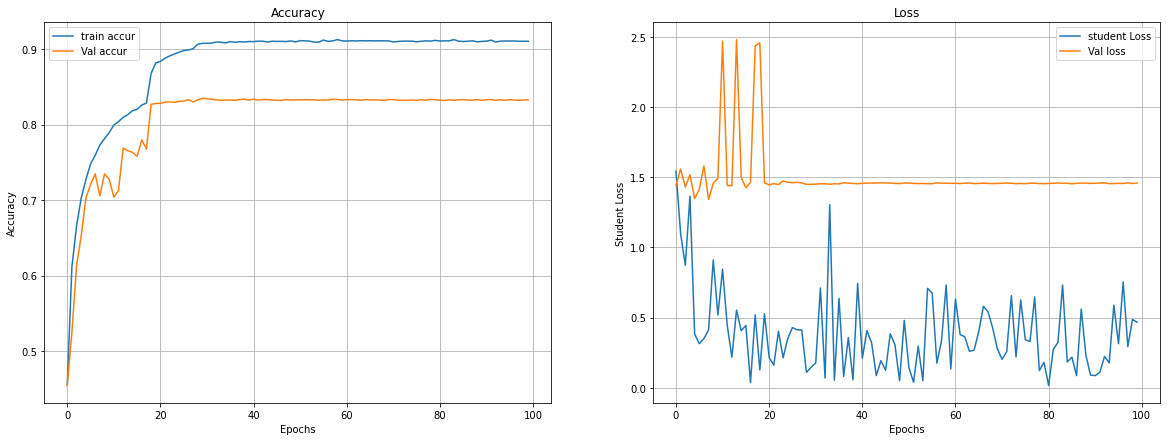

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.4/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 77s 48ms/step - sparse_categorical_accuracy: 0.4312 - student_loss: 1.5544 - Dist_loss: 1.4100 - loss: 2.2594 - val_sparse_categorical_accuracy: 0.4320 - val_student_loss: 3.4835 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6051 - student_loss: 1.1298 - Dist_loss: 1.1129 - loss: 1.6863 - val_sparse_categorical_accuracy: 0.5728 - val_student_loss: 1.5301 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.6740 - student_loss: 0.9583 - Dist_loss: 0.9624 - loss: 1.4395 - val_sparse_categorical_accuracy: 0.5153 - val_student_loss: 2.4298 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.7139 - student

Epoch 31/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9142 - student_loss: 0.2565 - Dist_loss: 0.3005 - loss: 0.4067 - val_sparse_categorical_accuracy: 0.8368 - val_student_loss: 1.4430 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9147 - student_loss: 0.2489 - Dist_loss: 0.2977 - loss: 0.3977 - val_sparse_categorical_accuracy: 0.8367 - val_student_loss: 1.4431 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9135 - student_loss: 0.2549 - Dist_loss: 0.2965 - loss: 0.4032 - val_sparse_categorical_accuracy: 0.8366 - val_student_loss: 1.4431 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9162 - student_loss: 0.2515 - Dist_loss: 0.2955 - loss: 0.3993 - val_sparse_categorical_accuracy: 0.8360 - val_student_loss: 1.4471 -

Epoch 61/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.9174 - student_loss: 0.2459 - Dist_loss: 0.2914 - loss: 0.3916 - val_sparse_categorical_accuracy: 0.8354 - val_student_loss: 1.4398 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9182 - student_loss: 0.2447 - Dist_loss: 0.2912 - loss: 0.3903 - val_sparse_categorical_accuracy: 0.8359 - val_student_loss: 1.4383 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9165 - student_loss: 0.2463 - Dist_loss: 0.2917 - loss: 0.3921 - val_sparse_categorical_accuracy: 0.8356 - val_student_loss: 1.4399 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9181 - student_loss: 0.2422 - Dist_loss: 0.2908 - loss: 0.3876 - val_sparse_categorical_accuracy: 0.8360 - val_student_loss: 1.4424 -

1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9181 - student_loss: 0.2428 - Dist_loss: 0.2906 - loss: 0.3881 - val_sparse_categorical_accuracy: 0.8365 - val_student_loss: 1.4388 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9167 - student_loss: 0.2456 - Dist_loss: 0.2915 - loss: 0.3913 - val_sparse_categorical_accuracy: 0.8360 - val_student_loss: 1.4360 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9182 - student_loss: 0.2447 - Dist_loss: 0.2910 - loss: 0.3901 - val_sparse_categorical_accuracy: 0.8361 - val_student_loss: 1.4378 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9174 - student_loss: 0.2407 - Dist_loss: 0.2902 - loss: 0.3858 - val_sparse_categorical_accuracy: 0.8359 - val_student_loss: 1.4392 - lr: 1.0000e-

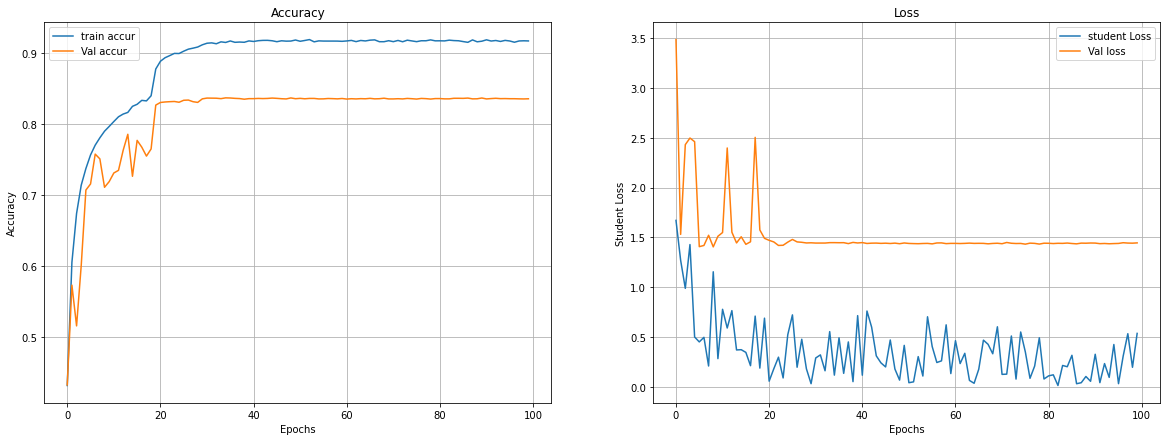

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.5/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 77s 47ms/step - sparse_categorical_accuracy: 0.4457 - student_loss: 1.5225 - Dist_loss: 1.3767 - loss: 2.3486 - val_sparse_categorical_accuracy: 0.4535 - val_student_loss: 2.3440 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.6046 - student_loss: 1.1468 - Dist_loss: 1.0973 - loss: 1.8052 - val_sparse_categorical_accuracy: 0.5815 - val_student_loss: 2.4898 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6592 - student_loss: 1.0107 - Dist_loss: 0.9647 - loss: 1.5895 - val_sparse_categorical_accuracy: 0.6301 - val_student_loss: 2.4302 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.6994 - student

Epoch 31/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9028 - student_loss: 0.2936 - Dist_loss: 0.3145 - loss: 0.4823 - val_sparse_categorical_accuracy: 0.8313 - val_student_loss: 1.4837 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9051 - student_loss: 0.2852 - Dist_loss: 0.3120 - loss: 0.4724 - val_sparse_categorical_accuracy: 0.8315 - val_student_loss: 1.4784 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 79s 50ms/step - sparse_categorical_accuracy: 0.9039 - student_loss: 0.2880 - Dist_loss: 0.3121 - loss: 0.4753 - val_sparse_categorical_accuracy: 0.8312 - val_student_loss: 1.4811 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9061 - student_loss: 0.2838 - Dist_loss: 0.3110 - loss: 0.4704 - val_sparse_categorical_accuracy: 0.8308 - val_student_loss: 1.4829 -

Epoch 61/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9075 - student_loss: 0.2783 - Dist_loss: 0.3071 - loss: 0.4625 - val_sparse_categorical_accuracy: 0.8306 - val_student_loss: 1.4904 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9054 - student_loss: 0.2829 - Dist_loss: 0.3080 - loss: 0.4677 - val_sparse_categorical_accuracy: 0.8315 - val_student_loss: 1.4882 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9075 - student_loss: 0.2778 - Dist_loss: 0.3070 - loss: 0.4620 - val_sparse_categorical_accuracy: 0.8312 - val_student_loss: 1.4878 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9064 - student_loss: 0.2807 - Dist_loss: 0.3079 - loss: 0.4654 - val_sparse_categorical_accuracy: 0.8312 - val_student_loss: 1.4864 -

1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9083 - student_loss: 0.2811 - Dist_loss: 0.3075 - loss: 0.4656 - val_sparse_categorical_accuracy: 0.8317 - val_student_loss: 1.4859 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9072 - student_loss: 0.2783 - Dist_loss: 0.3072 - loss: 0.4626 - val_sparse_categorical_accuracy: 0.8308 - val_student_loss: 1.4885 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9073 - student_loss: 0.2775 - Dist_loss: 0.3065 - loss: 0.4614 - val_sparse_categorical_accuracy: 0.8310 - val_student_loss: 1.4847 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9064 - student_loss: 0.2797 - Dist_loss: 0.3073 - loss: 0.4641 - val_sparse_categorical_accuracy: 0.8312 - val_student_loss: 1.4889 - lr: 1.0000e-

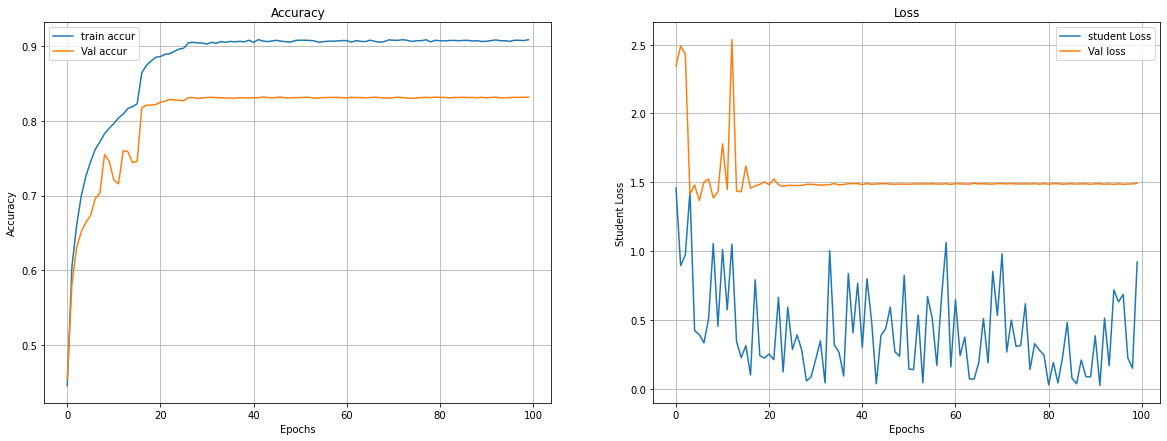

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.6/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 77s 47ms/step - sparse_categorical_accuracy: 0.4417 - student_loss: 1.5374 - Dist_loss: 1.3610 - loss: 2.4901 - val_sparse_categorical_accuracy: 0.3936 - val_student_loss: 3.4803 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.6022 - student_loss: 1.1657 - Dist_loss: 1.0792 - loss: 1.9211 - val_sparse_categorical_accuracy: 0.6092 - val_student_loss: 2.7068 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6632 - student_loss: 1.0185 - Dist_loss: 0.9400 - loss: 1.6766 - val_sparse_categorical_accuracy: 0.4168 - val_student_loss: 2.4801 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 77s 50ms/step - sparse_categorical_accuracy: 0.7018 - student

Epoch 31/100
1562/1562 [==============================] - 78s 50ms/step - sparse_categorical_accuracy: 0.9034 - student_loss: 0.2942 - Dist_loss: 0.2988 - loss: 0.5034 - val_sparse_categorical_accuracy: 0.8333 - val_student_loss: 1.4796 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9046 - student_loss: 0.2892 - Dist_loss: 0.2971 - loss: 0.4971 - val_sparse_categorical_accuracy: 0.8337 - val_student_loss: 1.4733 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9071 - student_loss: 0.2874 - Dist_loss: 0.2968 - loss: 0.4952 - val_sparse_categorical_accuracy: 0.8334 - val_student_loss: 1.4779 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9043 - student_loss: 0.2901 - Dist_loss: 0.2962 - loss: 0.4975 - val_sparse_categorical_accuracy: 0.8334 - val_student_loss: 1.4787 -

Epoch 61/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9069 - student_loss: 0.2824 - Dist_loss: 0.2926 - loss: 0.4873 - val_sparse_categorical_accuracy: 0.8352 - val_student_loss: 1.4790 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9068 - student_loss: 0.2836 - Dist_loss: 0.2927 - loss: 0.4885 - val_sparse_categorical_accuracy: 0.8355 - val_student_loss: 1.4800 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9086 - student_loss: 0.2789 - Dist_loss: 0.2920 - loss: 0.4833 - val_sparse_categorical_accuracy: 0.8353 - val_student_loss: 1.4801 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9072 - student_loss: 0.2818 - Dist_loss: 0.2926 - loss: 0.4866 - val_sparse_categorical_accuracy: 0.8351 - val_student_loss: 1.4820 -

1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9075 - student_loss: 0.2845 - Dist_loss: 0.2928 - loss: 0.4895 - val_sparse_categorical_accuracy: 0.8347 - val_student_loss: 1.4806 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9075 - student_loss: 0.2821 - Dist_loss: 0.2927 - loss: 0.4870 - val_sparse_categorical_accuracy: 0.8347 - val_student_loss: 1.4792 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9066 - student_loss: 0.2832 - Dist_loss: 0.2927 - loss: 0.4881 - val_sparse_categorical_accuracy: 0.8355 - val_student_loss: 1.4806 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9077 - student_loss: 0.2819 - Dist_loss: 0.2918 - loss: 0.4861 - val_sparse_categorical_accuracy: 0.8351 - val_student_loss: 1.4781 - lr: 1.0000e-

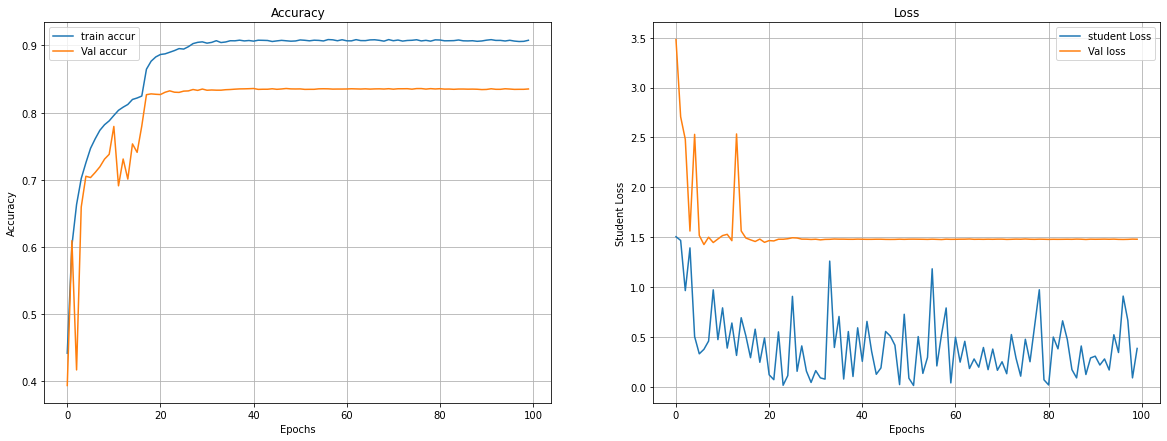

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.7/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 78s 47ms/step - sparse_categorical_accuracy: 0.4229 - student_loss: 1.5912 - Dist_loss: 1.3914 - loss: 2.7043 - val_sparse_categorical_accuracy: 0.4925 - val_student_loss: 2.5387 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.5847 - student_loss: 1.2187 - Dist_loss: 1.1057 - loss: 2.1033 - val_sparse_categorical_accuracy: 0.5658 - val_student_loss: 3.6252 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.6553 - student_loss: 1.0502 - Dist_loss: 0.9456 - loss: 1.8067 - val_sparse_categorical_accuracy: 0.6245 - val_student_loss: 1.4890 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.6916 - student

Epoch 31/100
1562/1562 [==============================] - 74s 48ms/step - sparse_categorical_accuracy: 0.8991 - student_loss: 0.3148 - Dist_loss: 0.3069 - loss: 0.5603 - val_sparse_categorical_accuracy: 0.8237 - val_student_loss: 1.4463 - lr: 1.0000e-03
Epoch 32/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.8996 - student_loss: 0.3124 - Dist_loss: 0.3053 - loss: 0.5567 - val_sparse_categorical_accuracy: 0.8248 - val_student_loss: 1.4474 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8980 - student_loss: 0.3149 - Dist_loss: 0.3054 - loss: 0.5592 - val_sparse_categorical_accuracy: 0.8251 - val_student_loss: 1.4433 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.8992 - student_loss: 0.3132 - Dist_loss: 0.3047 - loss: 0.5570 - val_sparse_categorical_accuracy: 0.8241 - val_student_loss: 1.4503 -

Epoch 61/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9019 - student_loss: 0.3055 - Dist_loss: 0.3000 - loss: 0.5455 - val_sparse_categorical_accuracy: 0.8244 - val_student_loss: 1.4523 - lr: 1.0000e-06
Epoch 62/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9009 - student_loss: 0.3105 - Dist_loss: 0.3017 - loss: 0.5519 - val_sparse_categorical_accuracy: 0.8238 - val_student_loss: 1.4531 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 75s 48ms/step - sparse_categorical_accuracy: 0.9013 - student_loss: 0.3033 - Dist_loss: 0.3002 - loss: 0.5435 - val_sparse_categorical_accuracy: 0.8244 - val_student_loss: 1.4500 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [==============================] - 79s 50ms/step - sparse_categorical_accuracy: 0.9018 - student_loss: 0.3040 - Dist_loss: 0.3005 - loss: 0.5444 - val_sparse_categorical_accuracy: 0.8235 - val_student_loss: 1.4531 -

1562/1562 [==============================] - 76s 48ms/step - sparse_categorical_accuracy: 0.9015 - student_loss: 0.3060 - Dist_loss: 0.3010 - loss: 0.5468 - val_sparse_categorical_accuracy: 0.8238 - val_student_loss: 1.4516 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 77s 49ms/step - sparse_categorical_accuracy: 0.9010 - student_loss: 0.3072 - Dist_loss: 0.2999 - loss: 0.5471 - val_sparse_categorical_accuracy: 0.8253 - val_student_loss: 1.4494 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9026 - student_loss: 0.3043 - Dist_loss: 0.2999 - loss: 0.5442 - val_sparse_categorical_accuracy: 0.8243 - val_student_loss: 1.4540 - lr: 1.0000e-06
Epoch 96/100
1562/1562 [==============================] - 76s 49ms/step - sparse_categorical_accuracy: 0.9017 - student_loss: 0.3072 - Dist_loss: 0.3005 - loss: 0.5476 - val_sparse_categorical_accuracy: 0.8252 - val_student_loss: 1.4515 - lr: 1.0000e-

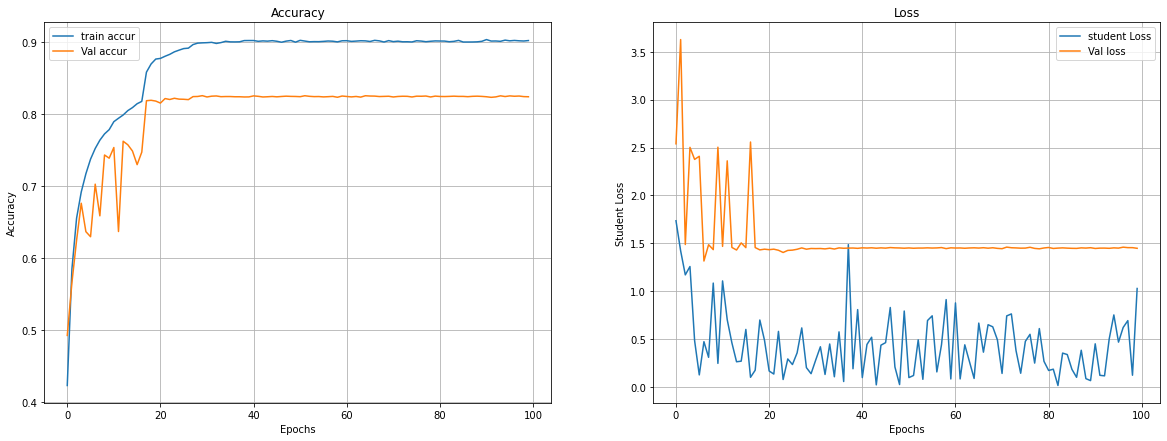

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.8/assets
Saving Done !
Saving Weights 
Saving Done !

End !
Epoch 1/100
1562/1562 [==============================] - 78s 47ms/step - sparse_categorical_accuracy: 0.4403 - student_loss: 1.5570 - Dist_loss: 1.3432 - loss: 2.7659 - val_sparse_categorical_accuracy: 0.5513 - val_student_loss: 2.5309 - lr: 0.1000
Epoch 2/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.5968 - student_loss: 1.2047 - Dist_loss: 1.0502 - loss: 2.1499 - val_sparse_categorical_accuracy: 0.5536 - val_student_loss: 3.6393 - lr: 0.1000
Epoch 3/100
1562/1562 [==============================] - 70s 45ms/step - sparse_categorical_accuracy: 0.6575 - student_loss: 1.0577 - Dist_loss: 0.9073 - loss: 1.8742 - val_sparse_categorical_accuracy: 0.5028 - val_student_loss: 2.4782 - lr: 0.1000
Epoch 4/100
1562/1562 [==============================] - 71s 45ms/step - sparse_categorical_accuracy: 0.6957 - student

1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9054 - student_loss: 0.2969 - Dist_loss: 0.2742 - loss: 0.5437 - val_sparse_categorical_accuracy: 0.8290 - val_student_loss: 1.4584 - lr: 0.0100
Epoch 32/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9109 - student_loss: 0.2776 - Dist_loss: 0.2696 - loss: 0.5202 - val_sparse_categorical_accuracy: 0.8298 - val_student_loss: 1.4385 - lr: 1.0000e-03
Epoch 33/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9121 - student_loss: 0.2758 - Dist_loss: 0.2667 - loss: 0.5158 - val_sparse_categorical_accuracy: 0.8312 - val_student_loss: 1.4430 - lr: 1.0000e-03
Epoch 34/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9138 - student_loss: 0.2739 - Dist_loss: 0.2647 - loss: 0.5121 - val_sparse_categorical_accuracy: 0.8311 - val_student_loss: 1.4510 - lr: 1.0000e-03
E

1563/1562 [==============================] - ETA: 0s - sparse_categorical_accuracy: 0.9150 - student_loss: 0.2647 - Dist_loss: 0.2597 - loss: 0.4985
Epoch 61: ReduceLROnPlateau reducing learning rate to 1e-06.
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9150 - student_loss: 0.2651 - Dist_loss: 0.2598 - loss: 0.4989 - val_sparse_categorical_accuracy: 0.8299 - val_student_loss: 1.4459 - lr: 1.0000e-05
Epoch 62/100
1562/1562 [==============================] - 73s 47ms/step - sparse_categorical_accuracy: 0.9158 - student_loss: 0.2667 - Dist_loss: 0.2606 - loss: 0.5012 - val_sparse_categorical_accuracy: 0.8303 - val_student_loss: 1.4468 - lr: 1.0000e-06
Epoch 63/100
1562/1562 [==============================] - 74s 47ms/step - sparse_categorical_accuracy: 0.9153 - student_loss: 0.2649 - Dist_loss: 0.2596 - loss: 0.4985 - val_sparse_categorical_accuracy: 0.8300 - val_student_loss: 1.4474 - lr: 1.0000e-06
Epoch 64/100
1562/1562 [=================

1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9166 - student_loss: 0.2637 - Dist_loss: 0.2599 - loss: 0.4976 - val_sparse_categorical_accuracy: 0.8306 - val_student_loss: 1.4460 - lr: 1.0000e-06
Epoch 93/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9151 - student_loss: 0.2675 - Dist_loss: 0.2604 - loss: 0.5019 - val_sparse_categorical_accuracy: 0.8303 - val_student_loss: 1.4509 - lr: 1.0000e-06
Epoch 94/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9143 - student_loss: 0.2647 - Dist_loss: 0.2600 - loss: 0.4988 - val_sparse_categorical_accuracy: 0.8294 - val_student_loss: 1.4434 - lr: 1.0000e-06
Epoch 95/100
1562/1562 [==============================] - 72s 46ms/step - sparse_categorical_accuracy: 0.9147 - student_loss: 0.2706 - Dist_loss: 0.2607 - loss: 0.5053 - val_sparse_categorical_accuracy: 0.8300 - val_student_loss: 1.4493 - lr: 1.0000e-

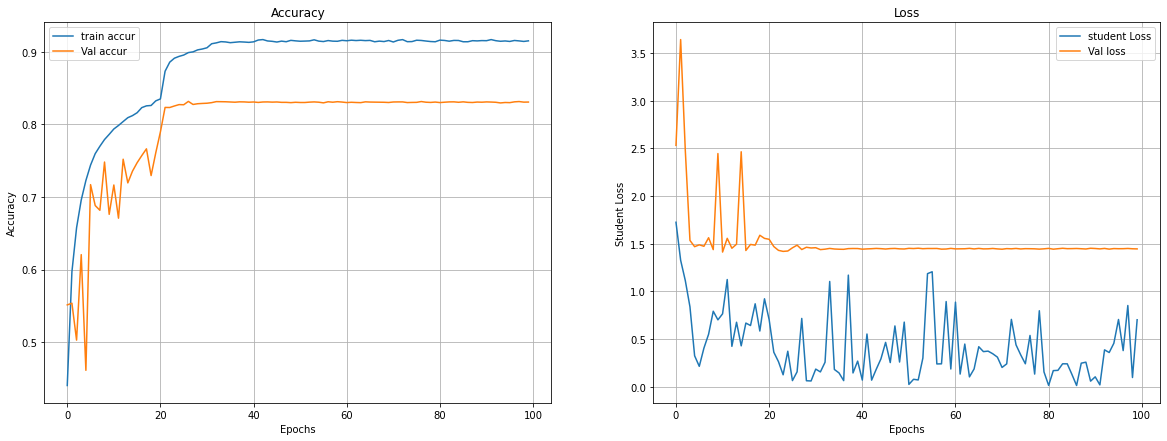

Saving model 
INFO:tensorflow:Assets written to: Resnet8_KD_notebook_beta0.9/assets
Saving Done !
Saving Weights 
Saving Done !

End !


In [10]:
for a in A:
    # Configuration du tensorboard
    NAME = f"Resnet8_kd_beta_{a}_temp5"
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir = f"logs/{NAME}", 
                                                 histogram_freq = 1)
    
    student = resnet_v1(input_shape=(32, 32, 3), depth= 8)
    student = tf.keras.Sequential([
        preprocessing,
        student,   
    ])

    dist = Distiller(teacher, student)

    dist.compile(
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
        distillation_loss_fn = tf.keras.losses.KLDivergence(),
        student_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        alpha = a,
        temperature = 5)

    # Train and evaluate on data.
    hist = dist.fit(x_train, y_train, 
          batch_size = BATCH_SIZE,
          epochs=EPOCHS,
          steps_per_epoch = len(x_train)/BATCH_SIZE,
          validation_data =(x_test, y_test),
          workers =40,
          use_multiprocessing= True,
          callbacks = [lr_reduce, tensorboard],
          )


    dist.evaluate(x_test, y_test)
    print("")

    print(" =============== History Plot ===============")
    plot_hist_kd(hist, f"Resnet8_KD_notebook_beta{a}.png")


    print("Saving model ")
    student.save(f"Resnet8_KD_notebook_beta{a}")
    print("Saving Done !")

    print("Saving Weights ")
    student.save_weights(f"w_resnet8_beta_{a}.h5")
    print("Saving Done !")
    print("")

    print("End !")